In [71]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics  import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,average_precision_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier as AdaBoostClassifier2
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt

In [3]:
# data visualizzation

In [ ]:
audio_file_path = '/Users/massimo/Desktop/Data Mining/Progetto/archive/fold1/7383-3-1-0.wav'

In [ ]:
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(librosa_audio_data)

In [ ]:
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [ ]:
wave_audio

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(wave_audio)

In [ ]:
mfcc_feat = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc = 40)

print(mfcc_feat.shape)

In [ ]:
mfcc_feat

In [ ]:
# dataset

In [6]:
audio_dataset_path = '/Users/massimo/Desktop/Data Mining/Progetto/archive'
metadata_path = pd.read_csv('/Users/massimo/Desktop/Data Mining/Progetto/archive/UrbanSound8K.csv')

In [7]:
metadata_path.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [17]:
#function for feature extraction
def audio_feature_extraction(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfcc_feat = librosa.feature.mfcc(y=audio, sr= sample_rate, n_mfcc=40)
    mfcc_scaled_features = np.mean(mfcc_feat.T, axis =0)
    return mfcc_scaled_features

In [18]:
# iterate through each file and extract features
extracted_features = []
for index_num, row in tqdm(metadata_path.iterrows()):
    #print(row[1][-1])
    #break
    #../input/urbansound8k/fold1/101415-3-0-2.wav
    #file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row[1][5])+'/',str(row[1][0]))
    #print(file_name)
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row['slice_file_name']))
    final_class_labels = row['class']#row[1][-1]
    data = audio_feature_extraction(file_name)
    extracted_features.append([data, final_class_labels])

3554it [07:05,  9.45it/s]/Users/massimo/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8325it [15:06, 15.91it/s]/Users/massimo/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
/Users/massimo/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [15:43,  9.26it/s]


In [19]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df
# save dataset
extracted_features_df.to_csv('/Users/massimo/Desktop/Data Mining/Progetto/archive/extracted_features_df.csv')

In [20]:
# read dataset
extracted_features_df = pd.read_csv('/Users/massimo/Desktop/Data Mining/Progetto/archive/extracted_features_df.csv')
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing
...,...,...
8727,"[-398.5845, 135.53496, -50.725018, 35.855907, ...",car_horn
8728,"[-346.4742, 86.34815, -45.16858, 51.709873, -3...",car_horn
8729,"[-303.88824, 111.35945, -45.941563, 35.877018,...",car_horn
8730,"[-344.11008, 125.45021, -54.903442, 34.891148,...",car_horn


In [21]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [22]:
X.shape

(8732, 40)

In [23]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

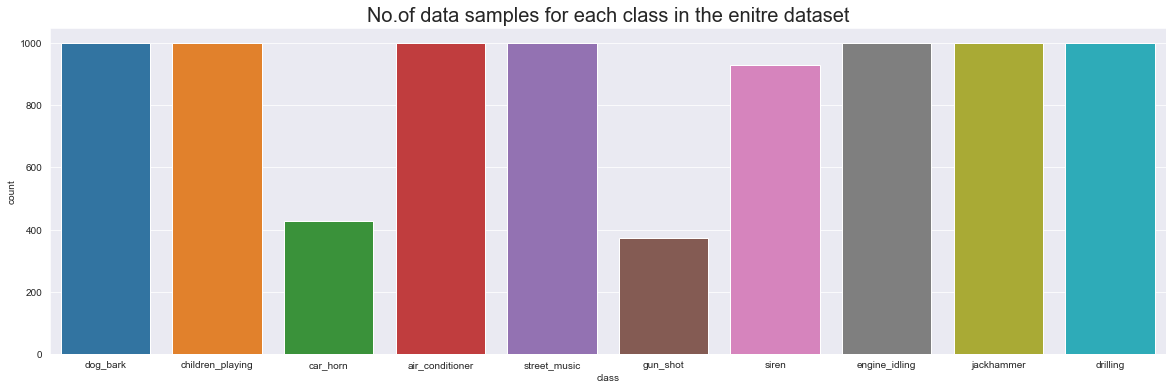

In [24]:
fig = plt.figure(figsize=(20,6))
plt.title("No.of data samples for each class in the enitre dataset", fontsize= 20)
sns.countplot(x ='class', data = extracted_features_df )
plt.show()

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state = 6, test_size=0.2)
x_train.shape, x_test.shape

((6985, 40), (1747, 40))

In [26]:
# test dataset originale, non bilanciato
# x_train & x_test

#Define cross-valudation method
n_folds = 10
skf = StratifiedKFold(n_folds, shuffle=True)

#Defnie parameters for features selection
#SelectKBest prameters
#Number of feature selected
TOP_K = [10, 20, 30, 40]
#Score function for evaluation
SCORE_F = [f_classif]

#Define scoring metrics
scoring = ['accuracy', 'precision_micro', 'recall_micro', 'f1_micro']

# category
category_id_df = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'enginge_idling', 'gun_shot', 'jackhammer', 'siren','street_music']

#x_train, x_test, y_train, y_test
def plot_cm(y_test, predicted):
    conf_mat = confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df, yticklabels=category_id_df)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [300]:
#from sklearn import preprocessing
#min_max_scaler = preprocessing.MinMaxScaler()
#x_norm = min_max_scaler.fit_transform(X)

In [301]:
# Evaluation of Linear Support Vector Classification
# KNeighborsClassifier().get_params().keys()
pipe = Pipeline([('clf',KNeighborsClassifier())])
grid = {
    'clf__n_neighbors': (np.arange(3,50,1))
}
grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

{'clf__n_neighbors': 3}


In [302]:
model.best_estimator_

Pipeline(steps=[('clf', KNeighborsClassifier(n_neighbors=3))])

In [303]:
model.best_score_

0.8791798710881492

In [304]:
#Defnie parameters for features selection
pipe_fsel = Pipeline([('selectkbest', SelectKBest()),('clf',KNeighborsClassifier())])

grid_fsel = {
    'clf__n_neighbors': [3],
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}

grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [305]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=40)),
                ('clf', KNeighborsClassifier(n_neighbors=3))])

In [306]:
model_fsel.best_score_

0.878265849892923

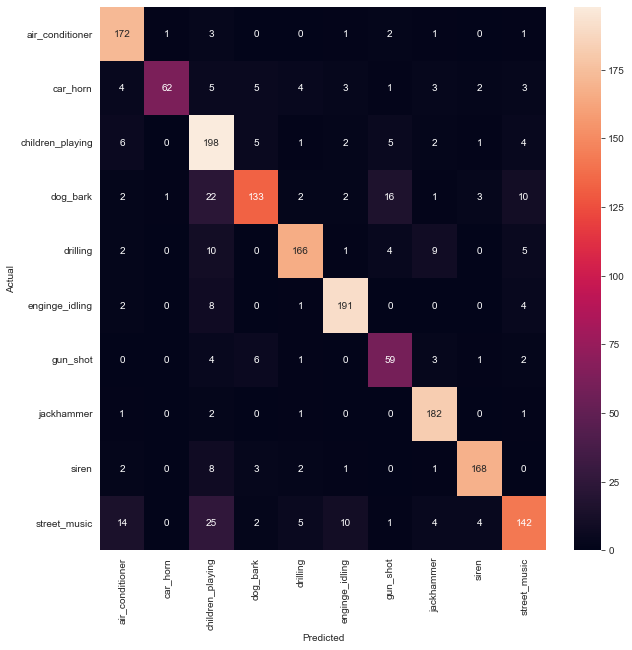

In [307]:
# matrix
select_k = SelectKBest(f_classif, k=40)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = KNeighborsClassifier(n_neighbors=3).fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)

plot_cm(y_test, predicted)

In [ ]:
#################################################

In [308]:
# Evaluation of RandomForestClassifier
# RandomForestClassifier().get_params().keys()
pipe = Pipeline([('clf',RandomForestClassifier())])
grid = {
   #'clf__max_depth': (np.arange(3,50,1)),
    'clf__n_estimators': (np.arange(3,70,1))
}
grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

{'clf__n_estimators': 67}


In [309]:
model.best_estimator_

Pipeline(steps=[('clf', RandomForestClassifier(n_estimators=67))])

In [310]:
model.best_score_

0.8978484984311969

In [311]:
pipe_fsel = Pipeline([('selectkbest', SelectKBest()), ('clf', RandomForestClassifier())])

grid_fsel = {
    'clf__n_estimators': [67] ,
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}

grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [312]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=40)),
                ('clf', RandomForestClassifier(n_estimators=67))])

In [313]:
model_fsel.best_score_

0.8914347537752194

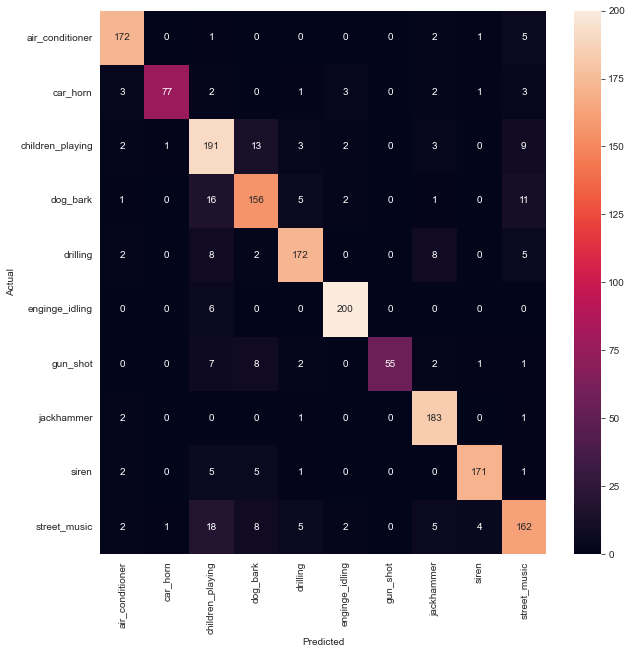

In [314]:
# matrix
select_k = SelectKBest(f_classif, k=40)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = RandomForestClassifier(n_estimators=67).fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)

plot_cm(y_test, predicted)

In [ ]:
#####################################

In [51]:
# Evaluation of Support Vector Machines
# SVC().get_params().keys()
pipe = Pipeline([('clf',SVC())])
grid = {
    'clf__C':[10, 1e2, 1e3],
    'clf__gamma':[1e-3, 1e-4, 5e-3]
}
grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

KeyboardInterrupt: 

In [319]:
model.best_estimator_

Pipeline(steps=[('clf', SVC(C=100.0, gamma=0.0001))])

In [320]:
model.best_score_

0.923843318890383

In [323]:
pipe_fsel = Pipeline([('selectkbest', SelectKBest()), ('clf', SVC())])

grid_fsel = {
    'clf__C':[100],
    'clf__gamma':[0.0001],
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}

grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [324]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=40)),
                ('clf', SVC(C=100, gamma=0.0001))])

In [325]:
model_fsel.best_score_

0.9247582575143971

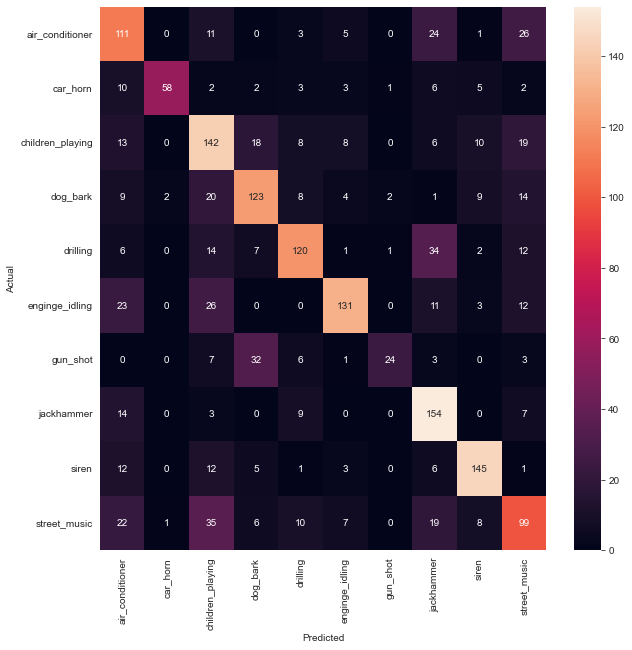

In [326]:
# matrix
select_k = SelectKBest(f_classif, k=40)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = SVC(C=100, gamma=0.0001).fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)

plot_cm(y_test, predicted)

In [ ]:
#######################################

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [335]:
# Evaluation of LogisticRegression
#LogisticRegression().get_params().keys()
pipe = Pipeline([('clf',LogisticRegression())])

grid = {
    #'clf__multi_class': ['ovr'],
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__max_iter': [1000]
}

grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

{'clf__max_iter': 1000, 'clf__multi_class': 'ovr', 'clf__solver': 'lbfgs'}


In [336]:
model.best_estimator_

Pipeline(steps=[('clf', LogisticRegression(max_iter=1000, multi_class='ovr'))])

In [337]:
model.best_score_

0.5924204654771547

In [331]:
pipe_fsel = Pipeline([('selectkbest', SelectKBest()), ('clf', LogisticRegression())])

grid_fsel = {
    #'clf__multi_class': ['ovr'],
    'clf__solver': [ 'liblinear'],
    'clf__max_iter': [1000],
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}

grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [332]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=40)),
                ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))])

In [333]:
model_fsel.best_score_

0.5903590029908179

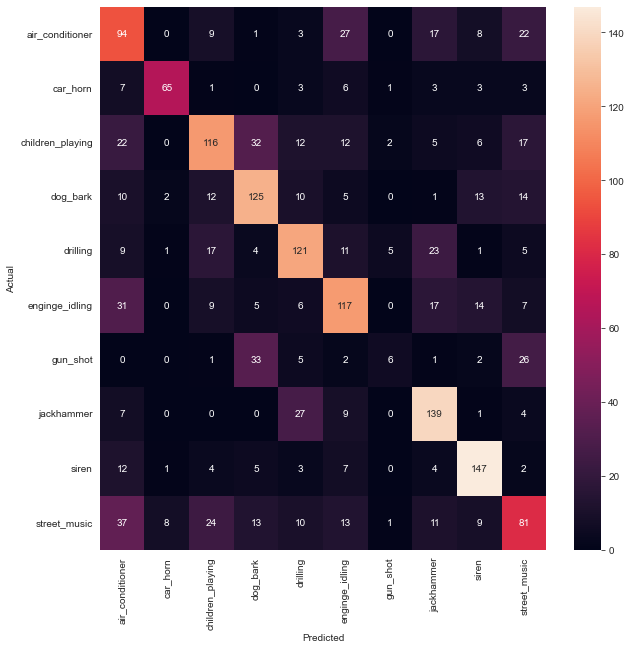

In [334]:
# matrix
select_k = SelectKBest(f_classif, k=40)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = LogisticRegression(max_iter=1000, solver='liblinear').fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)

plot_cm(y_test, predicted)

In [ ]:
#############################################################

In [53]:
from sklearn.naive_bayes import GaussianNB
GaussianNB().get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [342]:
#Gaussian Naive Bayes
#GaussianNB().get_params().keys()
pipe = Pipeline([('clf',GaussianNB())])
grid = {
}

grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

{}


In [343]:
model.best_estimator_

Pipeline(steps=[('clf', GaussianNB())])

In [344]:
model.best_score_

0.4775565463786465

In [345]:
pipe_fsel = Pipeline([('selectkbest', SelectKBest()), ('clf', GaussianNB())])

grid_fsel = {
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}
grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [346]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=20)), ('clf', GaussianNB())])

In [347]:
model_fsel.best_score_

0.4910675201375619

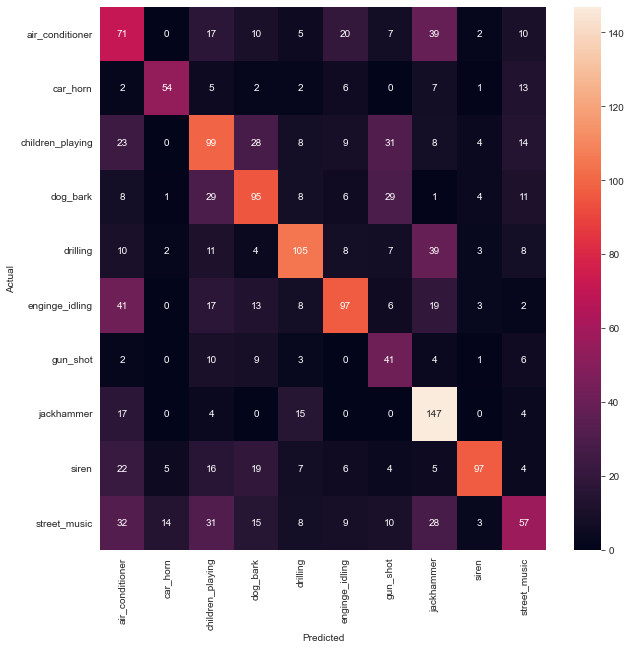

In [348]:
#matrix
select_k = SelectKBest(f_classif, k=20)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = GaussianNB().fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)

plot_cm(y_test, predicted)

In [ ]:
########################################

In [40]:
# AdaBoostClassifier + RandomForestClassifier
# AdaBoostClassifier().get_params().keys()
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('clf',AdaBoostClassifier())])
grid = {
    'clf__base_estimator': [RandomForestClassifier(n_estimators=67)],
    'clf__n_estimators':(np.arange(1,100,5))
}
grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

{'clf__base_estimator': RandomForestClassifier(n_estimators=67), 'clf__n_estimators': 31}


In [41]:
model.best_estimator_

Pipeline(steps=[('clf',
                 AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=67),
                                    n_estimators=31))])

In [42]:
model.best_score_

0.8987631749327001

In [44]:
pipe_fsel = Pipeline([('selectkbest', SelectKBest()), ('clf', AdaBoostClassifier())])

grid_fsel = {
    'clf__base_estimator': [RandomForestClassifier(n_estimators=67)],
    'clf__n_estimators': [31],
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}

grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [45]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=40)),
                ('clf',
                 AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=67),
                                    n_estimators=31))])

In [46]:
model_fsel.best_score_

0.8959030251558975

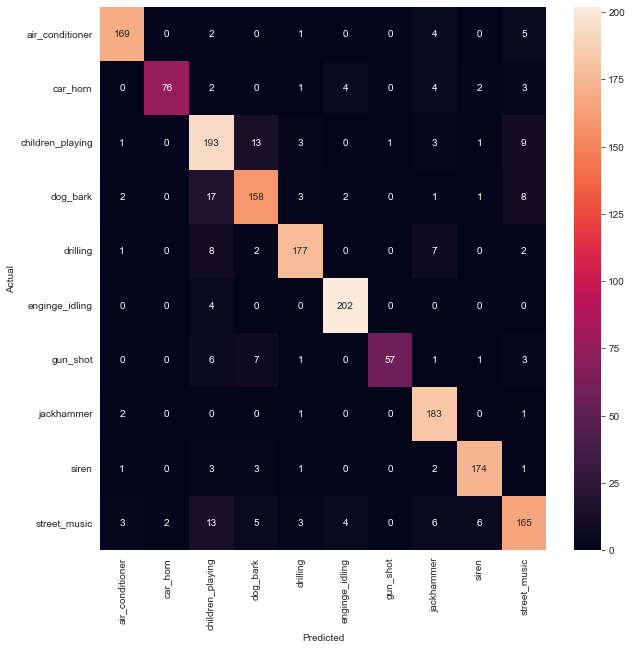

In [47]:
#matrix
select_k = SelectKBest(f_classif, k=40)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=67),n_estimators=31).fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)

plot_cm(y_test, predicted)

In [48]:
##################################################

In [57]:
# AdaBoostClassifier + RandomForestClassifier 1
# AdaBoostClassifier().get_params().keys()
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('clf', AdaBoostClassifier2())])
grid = {
    'clf__base_estimator': [RandomForestClassifier(n_estimators=1)],
    'clf__n_estimators': (np.arange(1, 100, 5))
}
grid_search = GridSearchCV(pipe, param_grid=grid, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model = grid_search.fit(X=X, y=y)

print(grid_search.best_params_)

{'clf__base_estimator': RandomForestClassifier(n_estimators=1), 'clf__n_estimators': 96}


In [58]:
model.best_estimator_

Pipeline(steps=[('clf',
                 AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=1),
                                    n_estimators=96))])

In [59]:
model.best_score_

0.8326835316290128

In [60]:
pipe_fsel = Pipeline([('selectkbest', SelectKBest()), ('clf', AdaBoostClassifier2())])

grid_fsel = {
    'clf__base_estimator': [RandomForestClassifier(n_estimators=1)],
    'clf__n_estimators': [96],
    'selectkbest__score_func': SCORE_F,
    'selectkbest__k': TOP_K
}

grid_search = GridSearchCV(pipe_fsel, param_grid=grid_fsel, scoring=scoring, refit="f1_micro", n_jobs=-1, cv=skf)
model_fsel = grid_search.fit(X=X, y=y)

In [61]:
model_fsel.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=40)),
                ('clf',
                 AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=1),
                                    n_estimators=96))])

In [62]:
model_fsel.best_score_

0.832227307398932

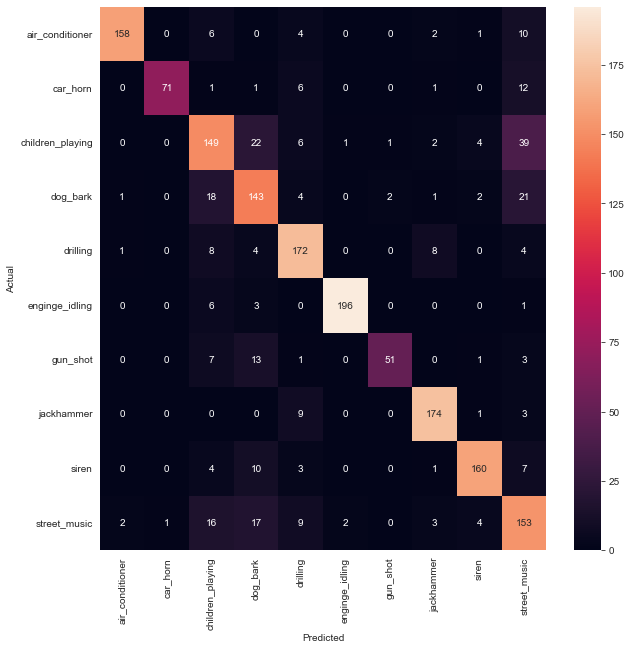

In [63]:
#matrix
select_k = SelectKBest(f_classif, k=40)
selected_features = select_k.fit_transform(x_train, y_train)
selected_features_test = select_k.transform(x_test)

clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=1), n_estimators=96).fit(selected_features, y_train)
predicted = clf.predict(selected_features_test)
plot_cm(y_test, predicted)

In [ ]:
##################################################

In [ ]:
# Comparison between classifiers tuned with best parameters

In [72]:
results = []
cols = ['classifier', 'accuracy', 'precision', 'recall', 'f1', 'time']
models = [
    KNeighborsClassifier(n_neighbors=3),
    RandomForestClassifier(n_estimators=67),
    SVC(C=100, gamma=0.0001),
    LogisticRegression(max_iter=1000, solver='liblinear'),
    GaussianNB(),
    AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=67),n_estimators=31),
    AdaBoostClassifier2(base_estimator=RandomForestClassifier(n_estimators=1), n_estimators=96)
]

In [73]:
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import plotly.graph_objects as go
import time

SKF = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, test_index in SKF.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    training_features = X_train
    testing_features = X_test

    for model in models:
        train_features = training_features
        test_features = testing_features
        model_name = model.__class__.__name__
        if(model_name == 'KNeighborsClassifier'):
            select_k = SelectKBest(f_classif, k=40)
            train_features = select_k.fit_transform(train_features, y_train)
            test_features = select_k.transform(test_features)
        if(model_name == 'RandomForestClassifier'):
            select_k = SelectKBest(f_classif, k=40)
            train_features = select_k.fit_transform(train_features, y_train)
            test_features = select_k.transform(test_features)
        if(model_name == 'SVC'):
            select_k = SelectKBest(f_classif, k=40)
            train_features = select_k.fit_transform(train_features, y_train)
            test_features = select_k.transform(test_features)
        if(model_name == 'LogisticRegression'):
            select_k = SelectKBest(f_classif, k=40)
            train_features = select_k.fit_transform(train_features, y_train)
            test_features = select_k.transform(test_features)
        if(model_name == 'GaussianNB'):
            select_k = SelectKBest(f_classif, k=20)
            train_features = select_k.fit_transform(train_features, y_train)
            test_features = select_k.transform(test_features)
        if(model_name == 'AdaBoostClassifier'):
            select_k = SelectKBest(f_classif, k=40)
            train_features = select_k.fit_transform(train_features, y_train)
            test_features = select_k.transform(test_features)
        if(model_name == 'AdaBoostClassifier2'):
            select_k = SelectKBest(f_classif, k=40)
            train_features = select_k.fit_transform(train_features, y_train)
            test_features = select_k.transform(test_features)
        start = time.process_time()
        clf = model.fit(train_features, y_train)
        time_tr = time.process_time() - start
        prediction_clf = clf.predict(test_features)
        acc = accuracy_score(y_test, prediction_clf)
        pre = precision_score(y_test, prediction_clf, average='weighted', zero_division=0)
        rec = recall_score(y_test, prediction_clf, average='weighted')
        f1 = f1_score(y_test, prediction_clf, average='weighted')
        results.append([model_name, acc, pre, rec, f1, time_tr])

df = pd.DataFrame(results, columns=cols)

fig = go.Figure()
x = df['classifier'].to_list()

fig.add_trace(go.Box(
    y=df['accuracy'].to_list(),
    x=x,
    name='accuracy',
    marker_color='#3D9970'
))

fig.add_trace(go.Box(
    y=df['precision'].to_list(),
    x=x,
    name='precision',
    marker_color='#FF4136'
))

fig.add_trace(go.Box(
    y=df['recall'].to_list(),
    x=x,
    name='recall',
    marker_color='#FF851B'
))

fig.add_trace(go.Box(
    y=df['f1'].to_list(),
    x=x,
    name='f1',
    marker_color='#33cc33'
))

fig.add_trace(go.Box(
    y=df['time'].to_list(),
    x=x,
    name='time',
    marker_color='#0066ff'
))

fig.update_layout(
    yaxis_title='score',
    boxmode='group'
)

fig.show()
#fig.write_image('movies/results.png')

df = df.sort_values(by=['classifier'])
df.to_csv('movies/raw_results.csv', float_format='%.3f', index=False)
df = df.groupby('classifier', as_index=False).mean()
df.to_csv('movies/results.csv', float_format='%.3f', index=False)

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [80]:
df = df.sort_values(by=['classifier'])
df.to_csv('movies/raw_results.csv', float_format='%.3f', index=False)
df = df.groupby('classifier', as_index=False).mean()
df.to_csv('movies/results.csv', float_format='%.3f', index=False)

In [ ]:
############################

In [ ]:
# T-test

In [81]:
from scipy.stats import ttest_ind
from scipy.stats import t
import pandas as pd

df = pd.read_csv("movies/raw_results.csv")
t, p = ttest_ind(df.loc[df['classifier'] == 'SVC', 'f1'].to_numpy(),
                 df.loc[df['classifier'] == 'RandomForestClassifier', 'f1'].to_numpy(), equal_var=False)
print("T_Test between SVC & RandomForestClassifier : T Value = {}, P Value = {}".format(t, p))

t, p = ttest_ind(df.loc[df['classifier'] == 'SVC', 'f1'].to_numpy(),
                 df.loc[df['classifier'] == 'KNeighborsClassifier', 'f1'].to_numpy(), equal_var=False)
print("T_Test between SVC & KNeighborsClassifier : T Value = {}, P Value = {}".format(t, p))

t, p = ttest_ind(df.loc[df['classifier'] == 'RandomForestClassifier', 'f1'].to_numpy(),
                 df.loc[df['classifier'] == 'KNeighborsClassifier', 'f1'].to_numpy(), equal_var=False)
print("T_Test between RandomForestClassifier & KNeighborsClassifier : T Value = {}, P Value = {}".format(t, p))

T_Test between SVC & RandomForestClassifier : T Value = 9.388084046498426, P Value = 4.543683016006161e-08
T_Test between SVC & KNeighborsClassifier : T Value = 7.692881858198347, P Value = 6.37376671661734e-06
T_Test between RandomForestClassifier & KNeighborsClassifier : T Value = 1.8457118675496647, P Value = 0.08674417714217879


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,random_state = 6, test_size=0.15)
x_train.shape, y_train.shape

In [ ]:
x_test

In [ ]:
fig = plt.figure(figsize=(20,6))
plt.title("No.of data samples for each class in the training dataset", fontsize= 20)
sns.countplot(y=y_train)
plt.show()

In [ ]:
temp_gun = []
temp_car = []

for i in range(len(y_train)):

    if y_train[i] == 'car_horn':
        temp_car.append(x_train[i])

    if y_train[i] == 'gun_shot':
        temp_gun.append(x_train[i])

In [ ]:
target_size = 685

t_s_car = target_size - len(temp_car)
t_s_gun = target_size - len(temp_gun)

print(t_s_car, t_s_gun)

In [ ]:
upsample_car = []
upsample_gun = []

y_up_car = []
y_up_gun = []

In [ ]:
from numpy import random

for i in range(t_s_car):
    ind = random.randint(0, len(temp_car)-1)
    upsample_car.append(temp_car[ind])
    y_up_car.append('car_horn')

for i in range(t_s_gun):
    ind = random.randint(0, len(temp_gun)-1)
    upsample_gun.append(temp_gun[ind])
    y_up_gun.append('gun_shot')

In [ ]:
x_train = list(x_train)
x_train = x_train + upsample_car + upsample_gun
print(len(x_train))

In [ ]:
y_train = list(y_train)
y_train = y_train + y_up_car + y_up_gun
print(len(y_train))

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)

In [ ]:
fig = plt.figure(figsize=(20,6))
plt.title("No.of data samples for each class in the training dataset after upsampling", fontsize= 20)
sns.countplot(y=y_train)
plt.show()

In [ ]:
x_train_n = x_train

In [ ]:
y_train_n = y_train

In [ ]:
print(x_train_n.shape, x_test.shape, y_train_n.shape, y_test.shape)

In [ ]:
x_val.shape , y_val.shape

In [ ]:
x_train_n1 = list(x_train_n)  + list(x_val)
y_train_n1 = list(y_train_n) + list(y_val)

x_train_n1 = np.array(x_train_n1)
y_train_n1 = np.array(y_train_n1)

In [ ]:
x_train_n1.shape , y_train_n1.shape

In [ ]:
y_train_pred_ada = clf_ada.predict(x_train_n1)

print("Training precision score is :-", precision_score(y_train_n1, y_train_pred_ada, average="macro"))
print("Training recall is :-", recall_score(y_train_n1, y_train_pred_ada, average="macro"))

In [ ]:
print("Testing accuracy is :-", clf_ada.score(x_test, y_test))

y_pred_ada = clf_ada.predict(x_test)
print()
print("Testing precision score is :-", precision_score(y_test, y_pred_ada, average="macro"))
print("Testing recall is :-", recall_score(y_test, y_pred_ada, average="macro"))
print()
print("Testing f1 score is :-", f1_score(y_test, y_pred_ada, average="macro"))

In [ ]:
import seaborn as sns

confusion_mat = confusion_matrix(y_test, y_pred_ada)

plt.figure(figsize=(10,4))

plt.xlabel("Predicted class")
plt.ylabel("True class")

sns.heatmap(confusion_mat, annot=True, cmap="Blues", xticklabels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'enginge_idling', 'gun_shot', 'jackhammer', 'siren','street_music'],
           yticklabels=['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'enginge_idling', 'gun_shot', 'jackhammer', 'siren','street_music'])
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_ada))